In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from ngsolve import *
#from netgen import gui
from ngsolve.webgui import Draw

from netgen.geom2d import SplineGeometry
import scipy.sparse as sp


In [2]:
from netgen.geom2d import SplineGeometry
geo = SplineGeometry()
geo.AddRectangle( (0, 0), (2, 0.41), bcs = ("wall", "outlet", "wall", "inlet"))
geo.AddCircle ( (0.2, 0.2), r=0.05, leftdomain=0, rightdomain=1, bc="cyl")
mesh = Mesh( geo.GenerateMesh(maxh=0.08))
mesh.Curve(3)
Draw(mesh)
# viscosity
nu = 0.001



NGSWebGuiWidget(value={'ngsolve_version': '6.2.2007-10-g96d72092', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, …

In [3]:
k = 3
V = VectorH1(mesh,order=k, dirichlet="wall|cyl|inlet")
Q = H1(mesh,order=k-1)
X = FESpace([V,Q])

In [5]:
gfu = GridFunction(X)
ustart = GridFunction(X)
velocity = gfu.components[0]
uin = CoefficientFunction( (1.5*4*y*(0.41-y)/(0.41*0.41), 0) )
gfu.components[0].Set(uin, definedon=mesh.Boundaries("inlet"))
ustart = gfu
# Draw (Norm(gfu.components[0]), mesh, "velocity", sd=3)
Draw (gfu.components[0], mesh, "vel")
#Draw (ustart.components[0], mesh, "vel")



NGSWebGuiWidget(value={'ngsolve_version': '6.2.2007-10-g96d72092', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, …

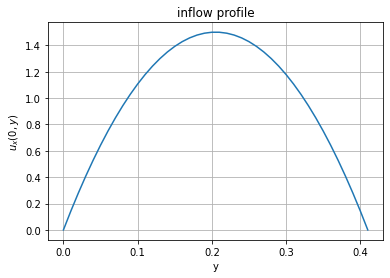

In [6]:
import matplotlib; import numpy as np; import matplotlib.pyplot as plt;
%matplotlib inline
s = np.arange(0.0, 0.42, 0.01)
bvs = 6*s*(0.41-s)/(0.41)**2
plt.plot(s, bvs)
plt.xlabel('y'); plt.ylabel('$u_x(0,y)$'); plt.title('inflow profile')
plt.grid(True)
plt.show()

# Newtons Method

In [9]:
(u,p), (v,q) = X.TnT()
J = BilinearForm(X)
J += (nu*InnerProduct(grad(u),grad(v))-div(u)*q-div(v)*p)*dx
J += InnerProduct(u,v)*dx
J += InnerProduct(grad(velocity)*velocity,v)*dx
J.Assemble()
inv_stokes = J.mat.Inverse(X.FreeDofs())

In [ ]:
(u,p), (v,q) = X.TnT()

a = BilinearForm(X)
stokes = (nu*InnerProduct(grad(u),grad(v))-div(u)*q-div(v)*p)*dx
a += stokes
a.Assemble()

f = LinearForm(X)
f.Assemble()

inv_stokes = a.mat.Inverse(X.FreeDofs())

res = f.vec.CreateVector()
res.data = f.vec - a.mat*gfu.vec
gfu.vec.data += inv_stokes * res

rows,cols,vals = a.mat.COO()
Ah = sp.csr_matrix((vals,(rows,cols)))


Fh = f.vec

Draw (gfu.components[0], mesh, "vel")

In [ ]:
dt = 0.001
dn = 1./dt
# matrix for implicit part of IMEX(1) scheme:
mstar = BilinearForm(X)
mstar += InnerProduct(u,v)*dx + dt*stokes
mstar.Assemble()

rows,cols,vals = mstar.mat.COO()
Mh_star = sp.csr_matrix((vals,(rows,cols)))

inv = mstar.mat.Inverse(X.FreeDofs())



conv = LinearForm(X)
conv += InnerProduct(grad(velocity)*velocity,v)*dx

In [ ]:
len(gfu.vec)

In [ ]:
t = 0
tend = 0
erg = np.zeros([len(gfu.vec),int(dn)])

In [ ]:
#Draw (gfu.components[0], mesh, "vel")
# implicit Euler/explicit Euler splitting method:
V_sb = MultiVector(gfu.vec, 1)
V_sb[0] = gfu.vec
tend += 1
d = 0
c = 1
#Draw(gfu)
while t < tend-0.5*dt:
    #print ("\rt=", t, end="")
    conv.Assemble()
    res.data = a.mat * gfu.vec + conv.vec
    #V_sb.AppendOrthogonalize(u_t_h.vec)
    gfu.vec.data -= dt * inv * res
    if d == 0:
        V_sb[0] = gfu.vec
    if d == (c*10)-1:
        c = c + 1
        V_sb.AppendOrthogonalize(gfu.vec)
        print(d,"do Orth: ")
    #V_sb.AppendOrthogonalize(gfu.vec)
    erg[:,d] = gfu.vec
    print(d)
    d = d + 1
    t = t + dt
    #Draw (gfu.components[0], mesh, "vel")
    Redraw()



In [ ]:
print(len(V_sb))
print(InnerProduct(V_sb[0],V_sb[99]))
V = np.zeros([len(gfu.vec),100])
for i in range(100):
    V[:,i] = np.array(V_sb[i])

In [ ]:
Draw (gfu.components[0], mesh, "vel")

In [ ]:
V_sb = MultiVector(gfu.vec, 1)
V_sb[0] = erg[:,0]

snap = 100
MaxTime = 1
iteration = 10000
dh = dn/snap
dtN = MaxTime/iteration
V = np.zeros([len(gfu.vec),snap])
for i in range(snap):
    V[:,i] = erg[:,int(i*dh)]

In [ ]:
V,R = np.linalg.qr(V)

In [ ]:
print(V[:,1].dot(V[:,99]))

In [ ]:
MN = np.transpose(V).dot(Mh_star.dot(V))
AN = np.transpose(V).dot(Ah.dot(V))
fN = np.transpose(V).dot(Fh)

In [ ]:
u_t_N = GridFunction(X)
uN = np.transpose(V).dot(ustart.vec)


In [ ]:
print(uN.shape)

In [ ]:
stokesinv = np.linalg.inv(AN)
res_N = fN - AN.dot(uN)
uN += stokesinv.dot(res_N)#
u_t_N.vec.FV().NumPy()[:] = (uN).dot(np.transpose(V))
Draw(u_t_N.components[0],mesh,name = "u_t_h")

In [ ]:
u_t_N = GridFunction(X)
uN = np.transpose(V).dot(ustart.vec)
#u_t_N.vec.FV().NumPy()[:] = (uN).dot(np.transpose(V))
Draw(ustart.components[0],mesh,name = "u_t_h")
stokesinv = np.linalg.inv(AN)
#inv_stokes = a.mat.Inverse(X.FreeDofs())

#res = f.vec.CreateVector()
res_N = fN - AN.dot(uN)
#uN = f.vec - a.mat*gfu.vec
uN += stokesinv.dot(res_N)#
u_t_N.vec.FV().NumPy()[:] = (uN).dot(np.transpose(V))
#Draw (gfu.components[0], mesh, "vel")
Draw(u_t_N.components[0],mesh,name = "u_t_h")
#Redraw()

In [ ]:
stokesinv.shape
res_N.shape

In [ ]:
Draw (u_t_N.components[0], mesh, "vel")